In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Collaborative Filtering

### Data Understanding

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')

### Data Preparation

In [4]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = rating['userId'].unique().tolist()
 
# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
 
# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [5]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = rating['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [6]:
# Mapping userId ke dataframe user
rating['user'] = rating['userId'].map(user_to_user_encoded)
 
# Mapping placeID ke dataframe movie
rating['movie'] = rating['movieId'].map(movie_to_movie_encoded)

In [7]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah movie
num_movie = len(movie_encoded_to_movie)
print(num_movie)
 
# Mengubah rating menjadi nilai float
rating['rating'] = rating['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(rating['rating'])
 
# Nilai maksimal rating
max_rating = max(rating['rating'])
 
print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

247753
33670
Number of User: 247753, Number of Resto: 33670, Min Rating: 0.5, Max Rating: 5.0


### Membagi Data untuk Training dan Validasi

In [13]:
# Mengacak dataset
rating_data = rating.sample(frac=0.1, random_state=42)
rating_data

,userId,movieId,rating,timestamp,user,movie
11079022,119464,47610,4.5,1186982523,119463,2247
21752061,235223,1222,4.0,1122557779,235222,1139
9140382,98696,2710,2.0,960345179,98695,395
16391073,177013,6365,4.0,1424502306,177012,776
7074693,76026,7236,4.0,1073539976,76025,7965
...,...,...,...,...,...,...
21885037,236707,551,5.0,966363054,236706,32
16938048,183076,65216,5.0,1308465206,183075,2788
7619638,81819,653,3.5,1121345497,81818,308
10165100,109637,3018,4.5,1223448802,109636,1556


In [14]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = rating[['user', 'movie']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [15]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [16]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [18]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25
2289/2289 [==============================] - 26s 11ms/step - loss: 0.6012 - root_mean_squared_error: 0.2027 - val_loss: 0.6564 - val_root_mean_squared_error: 0.2565
Epoch 2/25
2289/2289 [==============================] - 27s 12ms/step - loss: 0.5932 - root_mean_squared_error: 0.1937 - val_loss: 0.6540 - val_root_mean_squared_error: 0.2543
Epoch 3/25
2289/2289 [==============================] - 25s 11ms/step - loss: 0.5892 - root_mean_squared_error: 0.1891 - val_loss: 0.6520 - val_root_mean_squared_error: 0.2524
Epoch 4/25
2289/2289 [==============================] - 30s 13ms/step - loss: 0.5840 - root_mean_squared_error: 0.1829 - val_loss: 0.6499 - val_root_mean_squared_error: 0.2504
Epoch 5/25
2289/2289 [==============================] - 23s 10ms/step - loss: 0.5786 - root_mean_squared_error: 0.1765 - val_loss: 0.6482 - val_root_mean_squared_error: 0.2489
Epoch 6/25
2289/2289 [==============================] - 25s 11ms/step - loss: 0.5748 - root_mean_squared_error: 0.1719 -

### Visualisasi Metrik

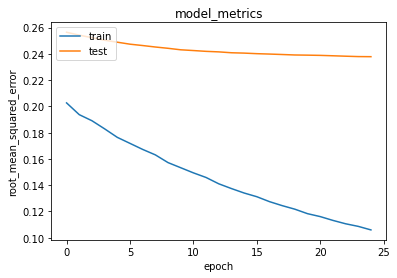

In [19]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Mendapatkan Rekomendasi Resto

In [23]:
movie_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/movies.csv')
 
# Mengambil sample user
user_id = rating.userId.sample(1).iloc[0]
movie_visited_by_user = rating[rating.userId == user_id]

movie_not_visited = movie_df[~movie_df['movieId'].isin(movie_visited_by_user.movieId.values)]['movieId'] 
movie_not_visited = list(
    set(movie_not_visited)
    .intersection(set(movie_to_movie_encoded.keys()))
)
 
movie_not_visited = [[movie_to_movie_encoded.get(x)] for x in movie_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_visited), movie_not_visited)
)

In [29]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title)

Showing recommendations for users: 59970
Movie with high ratings from user
--------------------------------
GoldenEye (1995)
--------------------------------
Top 10 movie recommendation
--------------------------------
Postman, The (Postino, Il) (1994)
Shawshank Redemption, The (1994)
Wallace & Gromit: A Close Shave (1995)
My Man Godfrey (1936)
To Kill a Mockingbird (1962)
Godfather: Part II, The (1974)
Treasure of the Sierra Madre, The (1948)
Man Who Would Be King, The (1975)
Pi (1998)
On the Waterfront (1954)
